In [1]:
import itertools
import random
import numpy 
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path 
import sys
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import warnings
from tabulate import tabulate
warnings.filterwarnings("ignore")
import copy

In [2]:
# ISSUE: focal_control.csv contains 13614 authors, but only 5459 of are the the collaboration.csv
# ISSUE: of those 5459 there are only 2861 granted and 2598 not_granted
# ISSUE: The "start_year" indicated in the focal_control.csv doesen't match the one in publication data

In [3]:
YEARS = [str(year) for year in range(1990,2019)]

In [4]:
df = pd.read_csv("myDATA/00-collaboration_df_with_starting_years.csv")

foc_con = pd.read_csv("Data/focal_controls.csv", index_col=0)

# get all collaboration for authors in focal_control.csv
foc_con = foc_con[foc_con["auth.id"].isin(df["ID"])]
foc_con = foc_con.drop("start_year", 1)
foc_con = pd.merge(foc_con, df, how='left', left_on=['auth.id'], right_on=['ID']).drop("ID", 1)

# separate granted and not
granted = foc_con[foc_con["focal"] == 1]
not_granted = foc_con[foc_con["focal"] == 0]

foc_con

,auth.id,group,focal,anr_year,1990,1991,1992,1993,1994,1995,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,start_year
0,6602860506,1,0,2010,0,0,0,0,0,0,...,4,11,11,11,11,11,11,11,11,1990
1,10143762200,10,1,2011,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,2003
2,12766889900,100,1,2016,0,0,0,0,0,0,...,20,20,20,20,40,40,40,40,40,2005
3,23569685800,100,0,2015,0,0,0,0,0,0,...,9,11,12,25,29,33,37,43,46,2007
4,24766427900,1000,1,2012,0,0,0,0,0,0,...,0,0,0,4,4,4,4,4,4,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454,7005280084,992,0,2014,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,2003
5455,24740874700,994,1,2014,0,0,0,0,0,0,...,14,35,40,46,61,79,83,88,111,2008
5456,7003626217,994,0,2009,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,1996
5457,6602299637,996,0,2007,0,0,0,0,0,0,...,29,40,42,44,45,45,48,48,52,2001


In [5]:
granted

,auth.id,group,focal,anr_year,1990,1991,1992,1993,1994,1995,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,start_year
1,10143762200,10,1,2011,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,2003
2,12766889900,100,1,2016,0,0,0,0,0,0,...,20,20,20,20,40,40,40,40,40,2005
4,24766427900,1000,1,2012,0,0,0,0,0,0,...,0,0,0,4,4,4,4,4,4,2003
7,24772993800,1003,1,2011,0,0,0,0,0,0,...,25,25,28,31,31,41,41,46,46,2006
9,24773509500,1004,1,2013,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5448,24721362500,987,1,2012,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,1999
5450,12766046000,99,1,2016,0,0,0,0,0,0,...,8,8,8,11,11,11,11,11,19,2006
5452,24725668200,991,1,2014,0,0,0,0,0,0,...,3,6,13,13,17,21,22,26,26,2008
5453,24729414600,992,1,2013,0,0,0,0,0,0,...,0,0,6,6,6,6,12,15,15,2006


In [6]:
not_granted

,auth.id,group,focal,anr_year,1990,1991,1992,1993,1994,1995,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,start_year
0,6602860506,1,0,2010,0,0,0,0,0,0,...,4,11,11,11,11,11,11,11,11,1990
3,23569685800,100,0,2015,0,0,0,0,0,0,...,9,11,12,25,29,33,37,43,46,2007
5,15131147900,1000,0,2005,0,0,0,0,0,0,...,0,7,7,7,7,7,7,7,7,1992
6,16315003800,1001,0,2007,0,0,0,0,0,0,...,3,3,3,3,3,7,7,7,8,1994
8,22135343900,1003,0,2015,0,0,0,0,0,0,...,31,42,59,63,64,72,81,87,103,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5451,7006892189,990,0,2007,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2,2,1991
5454,7005280084,992,0,2014,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,2003
5456,7003626217,994,0,2009,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,1996
5457,6602299637,996,0,2007,0,0,0,0,0,0,...,29,40,42,44,45,45,48,48,52,2001


In [7]:
# distribution of authors by start_year
data = []
for y in YEARS:
    df_y = foc_con[foc_con["start_year"] == int(y)]
    granted_y = granted[granted["start_year"] == int(y)]
    not_granted_y = not_granted[not_granted["start_year"] == int(y)]
    data.append([y, len(df_y), len(granted_y), len(not_granted_y)])
print (tabulate(data, headers=["Sarting Year", "tot", "granted", "not_granted"]))

  Sarting Year    tot    granted    not_granted
--------------  -----  ---------  -------------
          1990    772        337            435
          1991    307        153            154
          1992    292        135            157
          1993    292        138            154
          1994    258        133            125
          1995    250        113            137
          1996    312        147            165
          1997    274        144            130
          1998    241        127            114
          1999    244        119            125
          2000    294        171            123
          2001    253        151            102
          2002    293        162            131
          2003    256        146            110
          2004    262        157            105
          2005    244        146             98
          2006    195        134             61
          2007    137         79             58
          2008    109         63        

In [48]:
def plot_collab_traj(df):
    traj = {}
    plt.figure(figsize=(20, 8), dpi=80)
    legend = []
    for y in YEARS:
        df_y = df[df["start_year"] == int(y)]
        y_axis, x_axis = [], []
        for year in YEARS[YEARS.index(y):]:
            y_axis.append(df_y[year].mean()) 
            x_axis.append(int(year))

        num_auths = len(df_y)
        legend.append(y + " -> " + str(num_auths) + " authors")
        plt.plot(x_axis, y_axis)
        traj[y] = {"x": x_axis, "y": y_axis, "num_auths": num_auths}

            
    plt.xlabel("years ")
    plt.ylabel("avg num_collaboration")
    plt.xticks(rotation='vertical')
    plt.legend(legend)
    plt.show()
    return traj

In [49]:
def shift(json):
    plt.figure(figsize=(20, 8), dpi=80)
    legend = []
    idx = 28
    for y in YEARS:
        if(json[y]["num_auths"] != 0 and y!="2018"):
            
            json[y]["x"] = [int(year) for year in YEARS[0:idx]]
            json[y]["x"].insert(0, 0)
            
            legend.append(y)
            plt.plot([ i for i in range(len([str(x) for x in json[y]["x"]]))], json[y]["y"])
        idx -= 1
        
    plt.title("Shifted")
    plt.ylabel("avg num_collaboration")
    plt.xticks(rotation='vertical')
    plt.legend(legend)
    plt.show()
    return json

In [50]:
def func(t, a, sigma):
    return a* pow((np.log(t) + 1), sigma)

In [51]:
def fit_f(xdata, ydata, curr_x):

    popt, pcov = curve_fit(func, [(x)/curr_x for x in xdata], ydata, maxfev=25000)
    #print("alpha", popt[0], ", sigma", popt[1])
    
    return func([x/curr_x for x in xdata], *popt), popt[0], popt[1]

def fit_shift(json):

    plt.figure(figsize=(20, 8), dpi=80)
    legend = []
    idx = 28
    for y in YEARS:
        if(json[y]["num_auths"] != 0 and y!="2018"):
            
            
            fit_y, json[y]["alpha"], json[y]["sigma"] = fit_f(json[y]["x"], json[y]["y"], int(y))

            json[y]["fit_y"] = fit_y
            
            json[y]["x"] = [int(year) for year in YEARS[0:idx]]
            json[y]["x"].insert(0, 0)

            legend.append(y)
            plt.plot([ i for i in range(len([str(x) for x in json[y]["x"]]))], fit_y)
        idx -= 1
        
    plt.title("Fitted and Shifted")
    plt.ylabel("avg num_collaboration")
    plt.xticks(rotation='vertical')
    plt.legend(legend)
    plt.show()
    
    granted_data = []
    for y in YEARS:
        if(json[y]["num_auths"]>1):
            granted_data.append([y, json[y]["alpha"], json[y]["sigma"]])
    print (tabulate(granted_data, headers=["Sarting Year", "alpha", "sigma"]))
    
    return json

In [52]:
def fit_f_prolungate(xdata, ydata, curr_x):

    popt, pcov = curve_fit(func, [(x)/curr_x for x in xdata], ydata, maxfev=25000)
    #print("alpha", popt[0], ", sigma", popt[1])
    while(len(xdata) < len(YEARS)):
        xdata.append(xdata[-1]+1)
        
    
    return func([x/curr_x for x in xdata], *popt), popt[0], popt[1]

def fit_shift_prolungate(json):

    plt.figure(figsize=(20, 8), dpi=80)
    legend = []
    
    x_axis = YEARS[:-1]
    x_axis.insert(0,0)
    idx = 28
    for y in YEARS:
        if(json[y]["num_auths"] != 0 and y!="2018"):
            
            
            fit_y, json[y]["alpha"], json[y]["sigma"] = fit_f_prolungate(json[y]["x"], json[y]["y"], int(y))

            json[y]["fit_y"] = fit_y
            
            json[y]["x"] = [int(year) for year in YEARS[0:idx]]
            json[y]["x"].insert(0, 0)

            legend.append(y)
            

            plt.plot([ i for i in range(len(x_axis))], fit_y)
        idx -= 1
        
    plt.title("Fitted and Shifted and prolungated")
    plt.ylabel("avg num_collaboration")
    plt.xticks(rotation='vertical')
    plt.legend(legend)
    plt.show()
    
    granted_data = []
    for y in YEARS:
        if(json[y]["num_auths"]>1):
            granted_data.append([y, json[y]["alpha"], json[y]["sigma"]])
        json[y]["x"] = [int(x) for x in x_axis]
    print (tabulate(granted_data, headers=["Sarting Year", "alpha", "sigma"]))
    
    return json

In [57]:
# weighted average without prolungation 
def weighted_avg(shifted_json):
    plt.figure(figsize=(20, 8), dpi=80)
    avg_y = []
    for y in YEARS[:-1]:
        avg = 0
        num_f = 0
        asd = []
        for k in shifted_json:
            f = shifted_json[k]
            if(int(y) in f["x"]):
                if(f["y"][f["x"].index(int(y))] > 0 ):
                    avg += f["y"][f["x"].index(int(y))] * f["num_auths"]
                    num_f += 1
        avg_y.append(avg/num_f)
        
    plt.plot([ i for i in range(len(YEARS[:-1]))], avg_y)
    plt.title("Weighted and Shifted average")
    plt.xlabel("years ")
    plt.ylabel("weighted avg num_collaboration")
    plt.xticks(rotation='vertical')
    plt.show()
    return avg_y

def fit_shift_prolungate_avg(shifted_json):
    plt.figure(figsize=(20, 8), dpi=80)
    avg_y = []
    for y in YEARS[:-1]:
        avg = 0
        num_f = 0
        asd = []
        for k in shifted_json:
            f = shifted_json[k]
            if(int(y) in f["x"]):
                if(f["num_auths"] > 1):
                    if(f["fit_y"][f["x"].index(int(y))] > 0 ):
                        avg += f["fit_y"][f["x"].index(int(y))]
                        num_f += 1
        avg_y.append(avg/num_f)
        
    plt.plot([i for i in range(len(YEARS[:-1]))], avg_y)
    plt.title("Fitted Shifted and Prolunged average")
    plt.ylabel("avg num_collaboration")
    plt.xticks(rotation='vertical')
    plt.show()
    return avg_y

=================================================================  Granted  ==================================================================


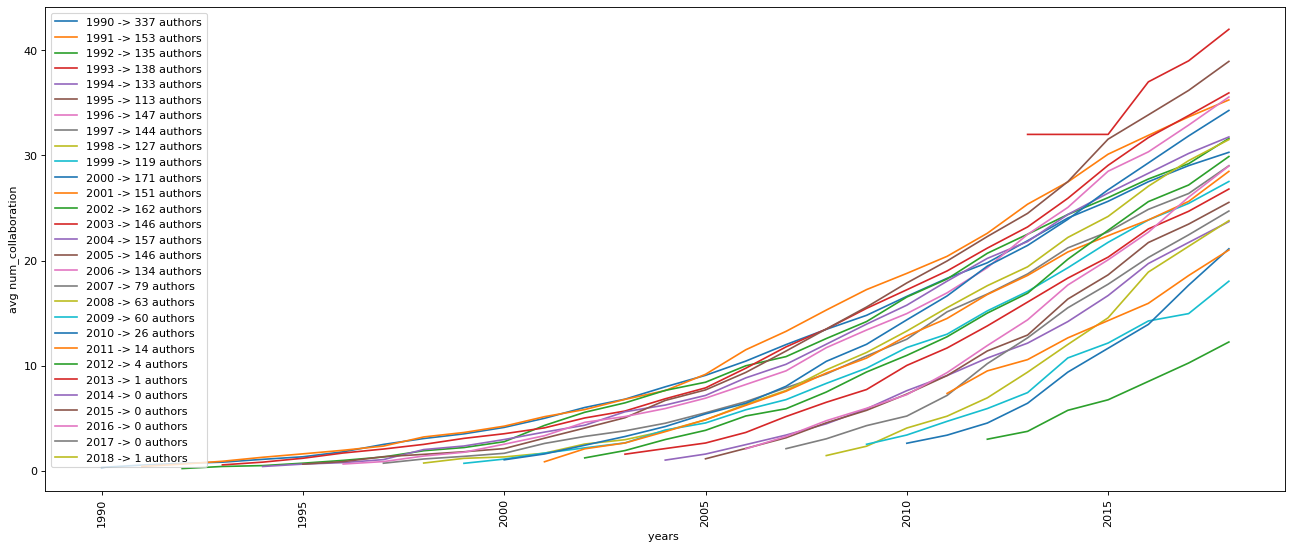

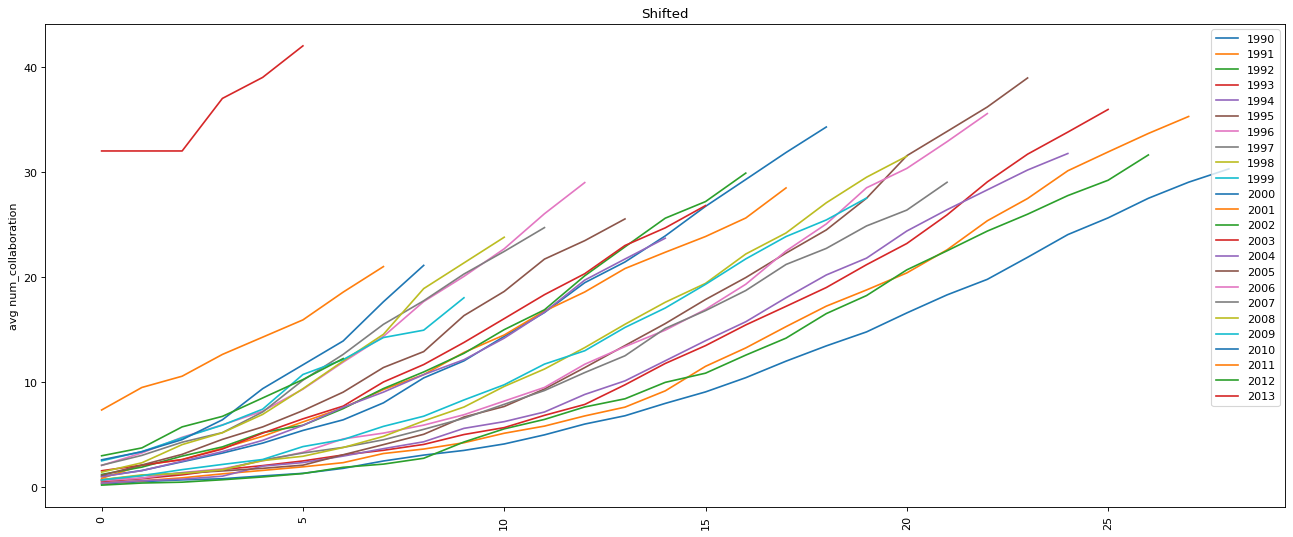

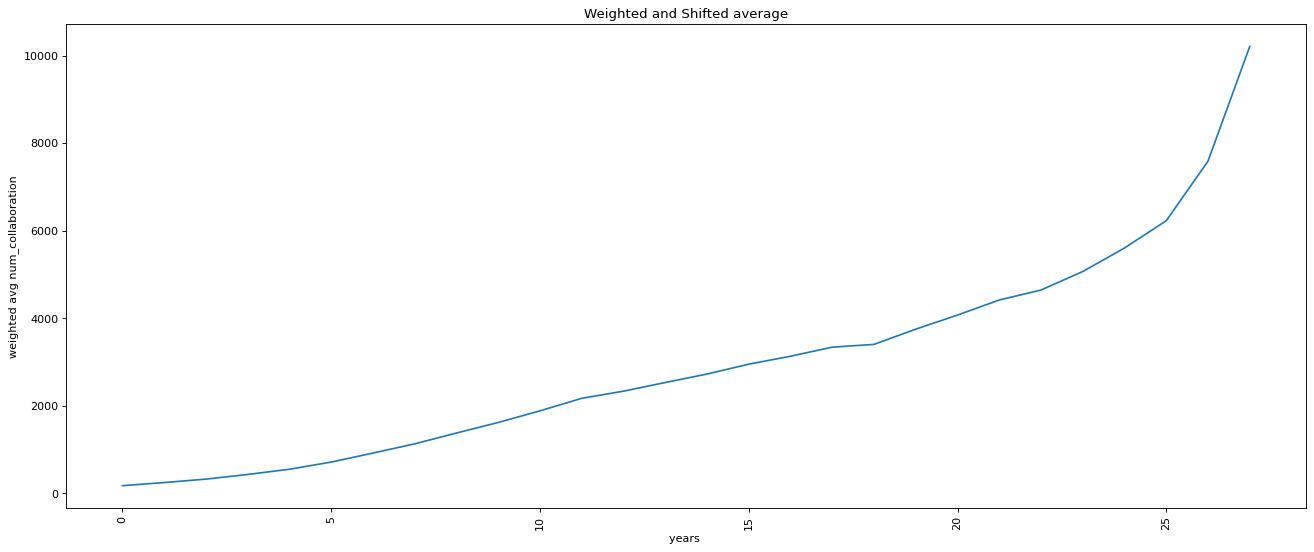

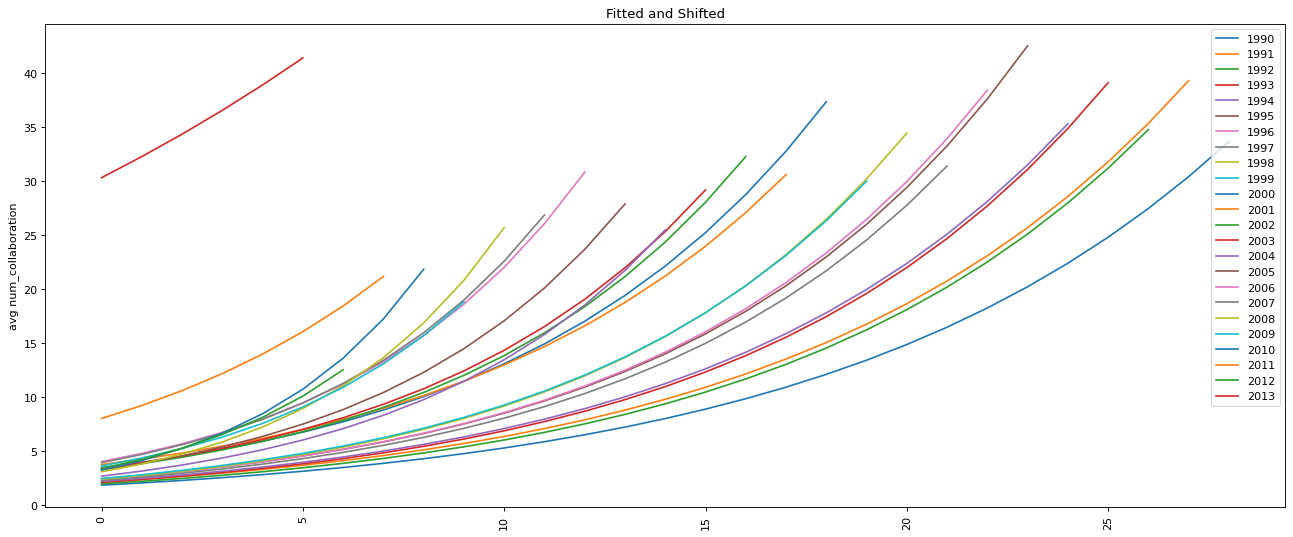

  Sarting Year    alpha    sigma
--------------  -------  -------
          1990  1.88231  207.904
          1991  2.16245  216.783
          1992  2.00512  221.486
          1993  2.14441  234.421
          1994  2.23716  232.026
          1995  2.45264  250.354
          1996  2.43216  253.206
          1997  2.32238  250.301
          1998  2.42372  267.865
          1999  2.49493  264.18
          2000  3.50201  265.409
          2001  3.79036  248.017
          2002  3.3568   285.544
          2003  3.43693  287.889
          2004  2.71158  323.091
          2005  3.30403  331.214
          2006  4.06727  340.744
          2007  3.96848  351.001
          2008  3.11355  426.135
          2009  3.6627   367.293
          2010  3.28597  478.108
          2011  8.05758  278.903
          2012  3.43351  436.263


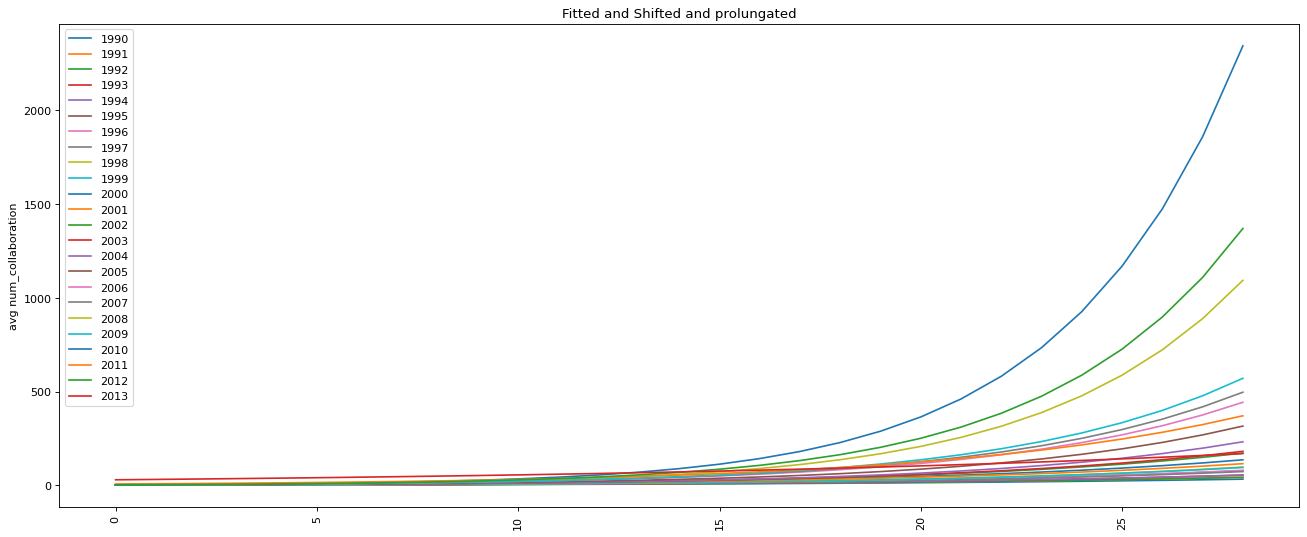

  Sarting Year    alpha    sigma
--------------  -------  -------
          1990  1.88231  207.904
          1991  2.16245  216.783
          1992  2.00512  221.486
          1993  2.14441  234.421
          1994  2.23716  232.026
          1995  2.45264  250.354
          1996  2.43216  253.206
          1997  2.32238  250.301
          1998  2.42372  267.865
          1999  2.49493  264.18
          2000  3.50201  265.409
          2001  3.79036  248.017
          2002  3.3568   285.544
          2003  3.43693  287.889
          2004  2.71158  323.091
          2005  3.30403  331.214
          2006  4.06727  340.744
          2007  3.96848  351.001
          2008  3.11355  426.135
          2009  3.6627   367.293
          2010  3.28597  478.108
          2011  8.05758  278.903
          2012  3.43351  436.263


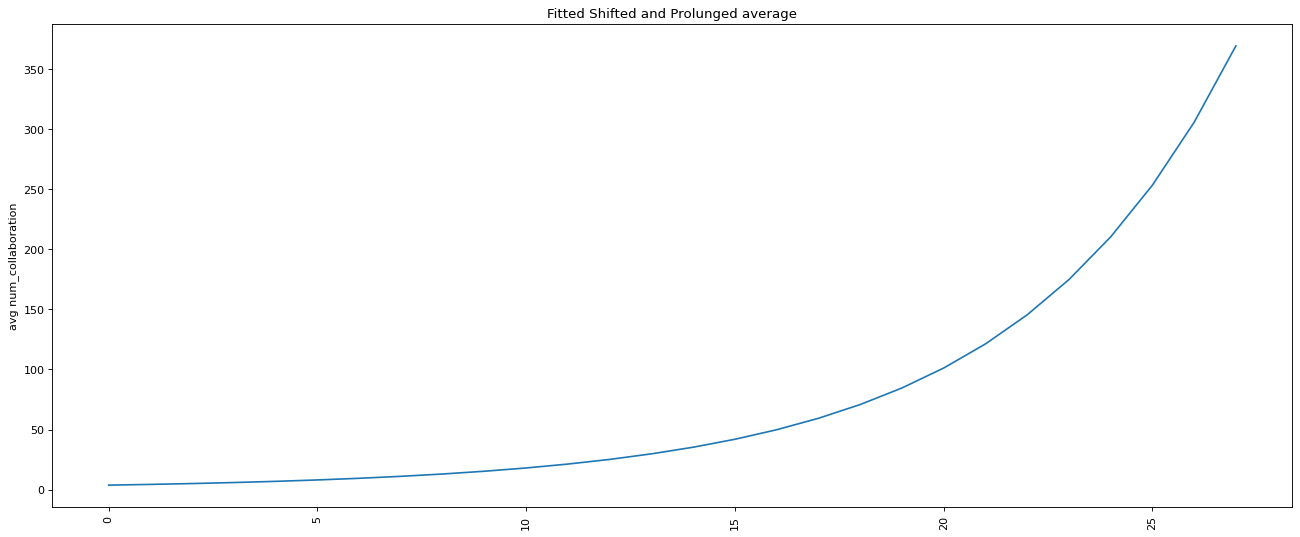

In [58]:
# granted_traj[year] = {"x": x_axis, "y": y_axis, "num_auths": num_auths}
print((' \033[1m' + " Granted "+'\033[0m ').center(150, '='))
granted_traj = plot_collab_traj(granted)

shifted_granted = shift(copy.deepcopy(granted_traj))
shifted_granted_avg_y = weighted_avg(copy.deepcopy(shifted_granted))

granted_fit_shif = fit_shift(copy.deepcopy(granted_traj))
granted_fit_shif_prol = fit_shift_prolungate(copy.deepcopy(granted_traj))

granted_fit_shif_prol_avg_y = fit_shift_prolungate_avg(copy.deepcopy(granted_fit_shif_prol))
print()

===============================================================  Not Granted  ================================================================


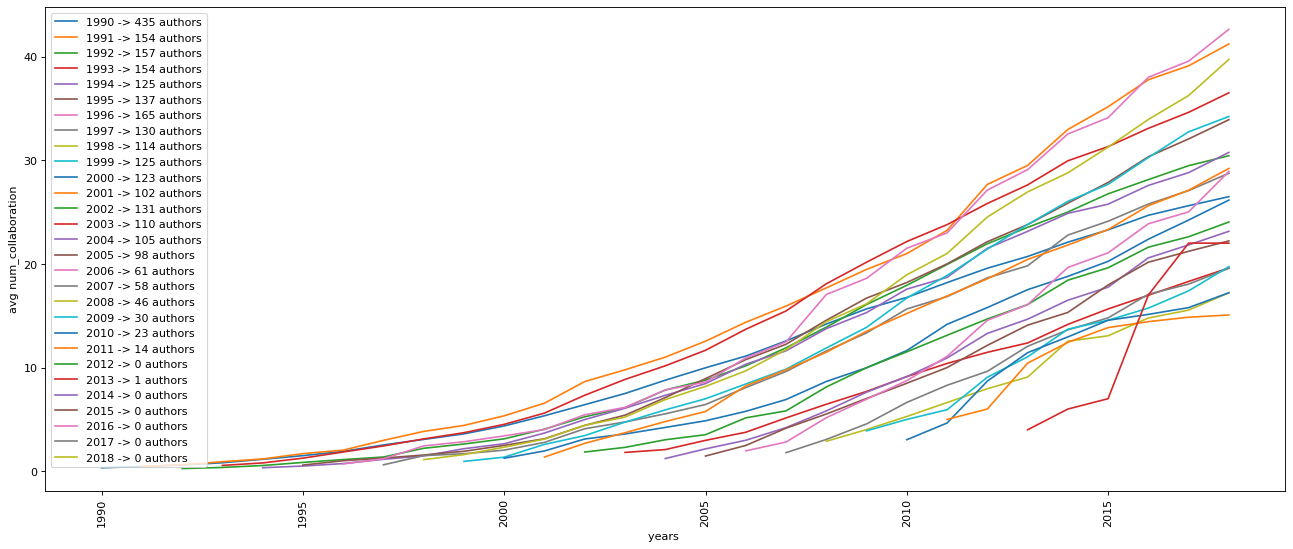

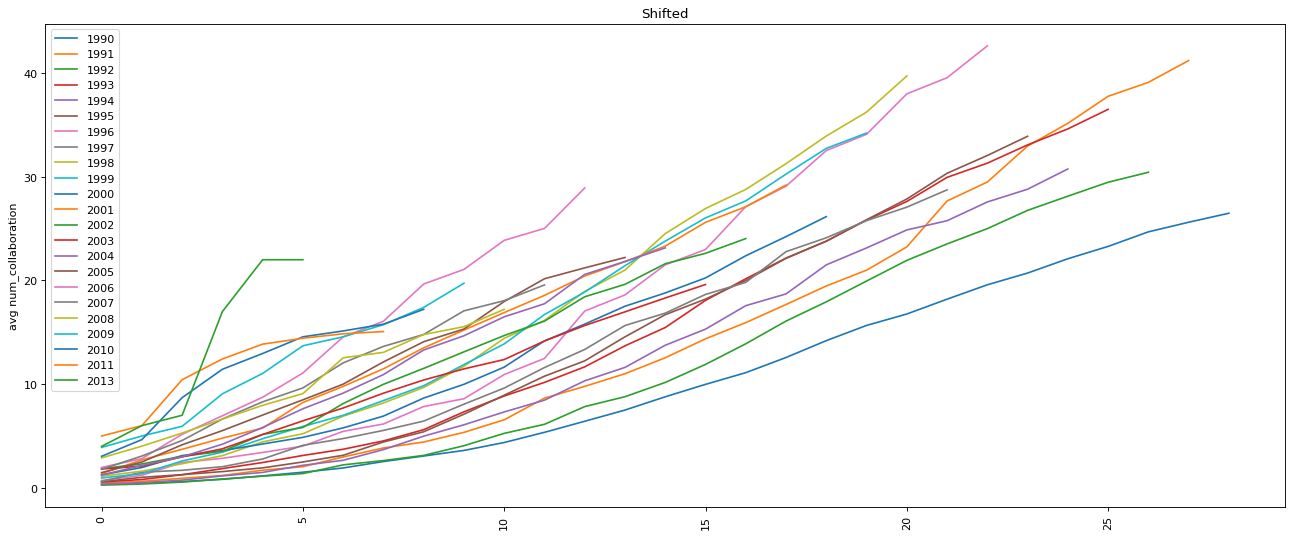

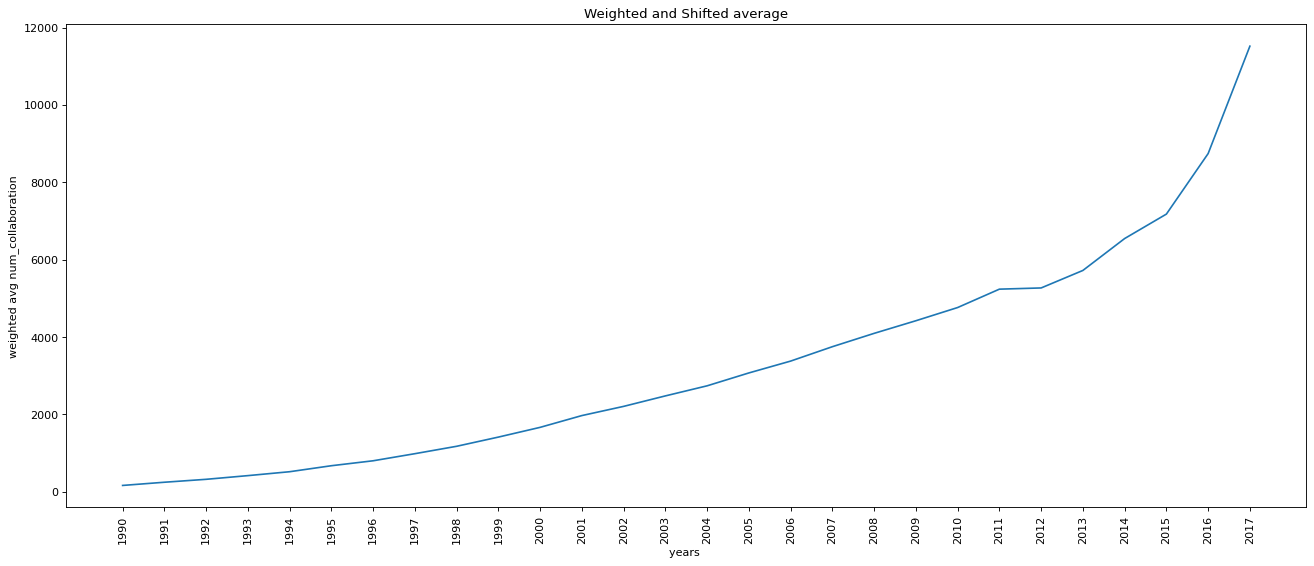

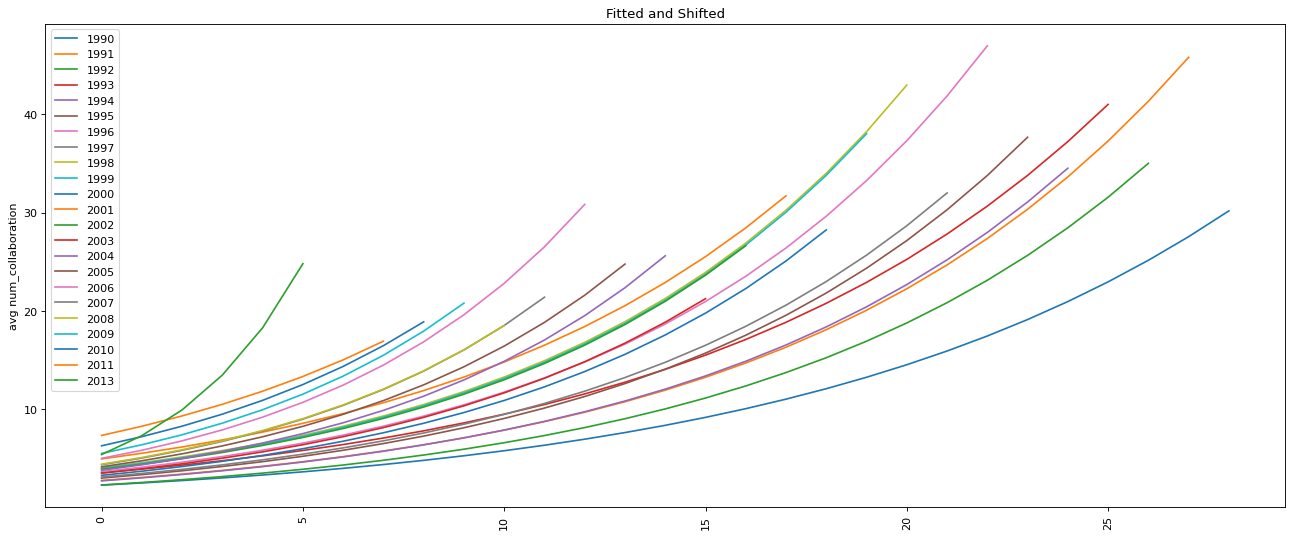

  Sarting Year    alpha    sigma
--------------  -------  -------
          1990  2.27356  186.34
          1991  2.75086  210.177
          1992  2.28785  211.72
          1993  3.53551  197.821
          1994  2.70803  213.985
          1995  2.98827  222.315
          1996  3.64567  234.417
          1997  3.09527  224.441
          1998  4.04903  238.316
          1999  3.98179  239.626
          2000  3.27194  241.627
          2001  4.93746  220.736
          2002  3.89222  242.527
          2003  3.48522  243.133
          2004  3.78622  275.486
          2005  4.13769  277.697
          2006  4.99858  305.934
          2007  4.34669  292.301
          2008  4.39985  289.82
          2009  5.49937  298.134
          2010  6.27466  277.932
          2011  7.32947  241.095


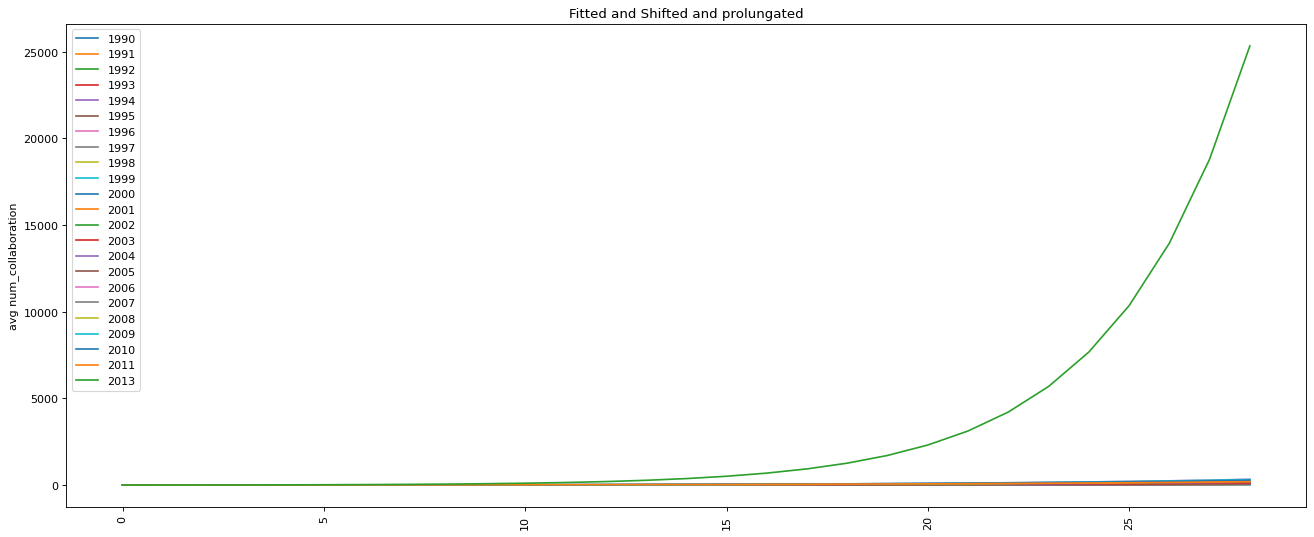

  Sarting Year    alpha    sigma
--------------  -------  -------
          1990  2.27356  186.34
          1991  2.75086  210.177
          1992  2.28785  211.72
          1993  3.53551  197.821
          1994  2.70803  213.985
          1995  2.98827  222.315
          1996  3.64567  234.417
          1997  3.09527  224.441
          1998  4.04903  238.316
          1999  3.98179  239.626
          2000  3.27194  241.627
          2001  4.93746  220.736
          2002  3.89222  242.527
          2003  3.48522  243.133
          2004  3.78622  275.486
          2005  4.13769  277.697
          2006  4.99858  305.934
          2007  4.34669  292.301
          2008  4.39985  289.82
          2009  5.49937  298.134
          2010  6.27466  277.932
          2011  7.32947  241.095


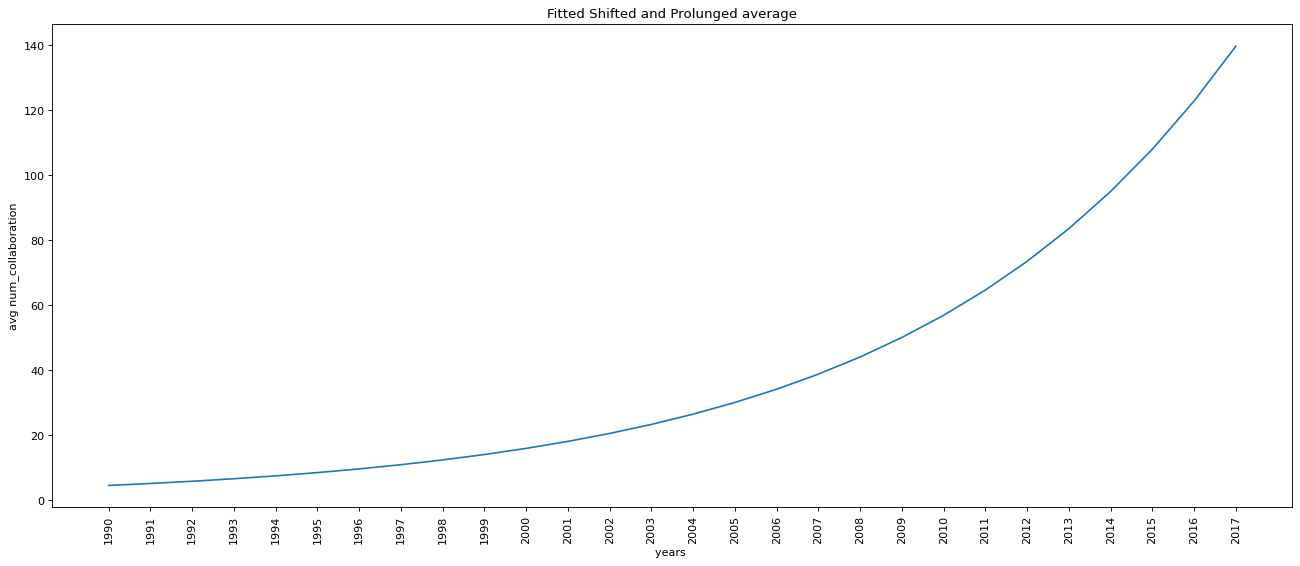

In [55]:
# not_granted_traj[year] = {"x": x_axis, "y": y_axis, "num_auths": num_auths}
print((' \033[1m' + " Not Granted "+'\033[0m ').center(150, '='))
not_granted_traj = plot_collab_traj(not_granted)
shifted_not_granted = shift(copy.deepcopy(not_granted_traj))
shifted_not_granted_avg_y = weighted_avg(copy.deepcopy(shifted_not_granted))

not_granted_fit_shif = fit_shift(copy.deepcopy(not_granted_traj))
not_granted_fit_shif_prol = fit_shift_prolungate(copy.deepcopy(not_granted_traj))

not_granted_fit_shif_prol_avg_y = fit_shift_prolungate_avg(copy.deepcopy(not_granted_fit_shif_prol))
print()